In [5]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Math_6397/CH01

/content/drive/MyDrive/Math_6397/CH01


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import torch
import torch.nn as nn 
from tqdm import tqdm

In [8]:
mat_contents = scipy.io.loadmat(os.path.join('..','DATA','CYLINDER_ALL.mat'))
X = mat_contents['VORTALL']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 12})

In [19]:
P = 0.4

Train = X[:, :int(X.shape[1]*P)]
Test = X[:, int(X.shape[1]*P)-1:]

torch.manual_seed(0)
load = torch.utils.data.DataLoader(Train.T, batch_size=2)

In [10]:
class Feedforward(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
                                nn.Linear(self.input_dim, self.input_dim),
                                nn.GELU(),
                                nn.Linear(self.input_dim, self.input_dim)
        )

    def forward(self, x):
        return self.net(x)

    
class Model(Feedforward):
    def __init__(self, shapes, lr=1e-2):
        self.input_dim = shapes[0]
        self.num_bins = shapes[1]
        self.learn_rate = lr
        super().__init__()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learn_rate)
        self.bin_pred = []
        self.loss = []
        self.vd = []

    def bins(self, max_layer_input, divider):
        return [(i*max_layer_input//divider, (i+1)*max_layer_input//divider) for i in range(divider)]
    
    def train(self, data_loader, iters):
        for iter in tqdm(range(iters)):
            for samp_idx, (train, test) in enumerate(data_loader):
                for (start, end) in self.bins(self.input_dim*self.num_bins, self.num_bins):
                    train_bin, test_bin = train[start:end].float(), test[start:end].float()
                    net_real = self.net(train_bin)
                    self.bin_pred.append(net_real)

                    self.optimizer.zero_grad()
                    loss = nn.MSELoss()(net_real, test_bin)
                    loss.backward()
                    self.optimizer.step()

                    
                self.loss.append(nn.MSELoss()(torch.ravel(torch.stack(self.bin_pred)), test).data.item())
                self.bin_pred = []
                    
    def predict(self, data_loader):
        self.bin_pred = []
        for pair_idx, (X_test, Y_test) in enumerate(data_loader):
            for (start, end) in self.bins(self.input_dim*self.num_bins, self.num_bins):
                X_test_bin, Y_test_bin = X_test[start:end].float(), Y_test[start:end].float()
                net_real = self.net(X_test_bin)
                self.bin_pred.append(net_real)

            self.vd.append(nn.MSELoss()(torch.ravel(torch.stack(self.bin_pred)), Y_test).data.item())
            self.bin_pred = []
                
    def trainplot(self):
        plt.plot(self.loss)
        plt.title('Training Loss')

    def testplot(self):
        plt.plot(self.vd)
        plt.title('Testing Loss')

In [20]:
#Model training

net = Model(shapes=(n,m), lr=1e-2)
net.train(load, 50)

100%|██████████| 50/50 [1:00:59<00:00, 73.19s/it] 


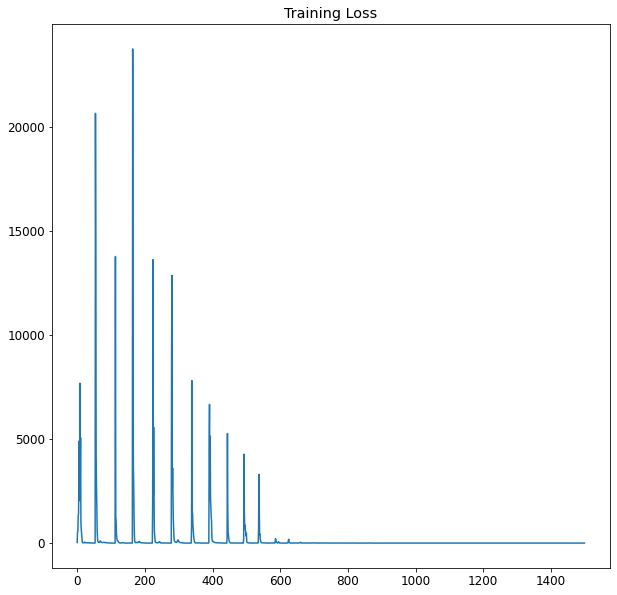

In [21]:
net.trainplot()

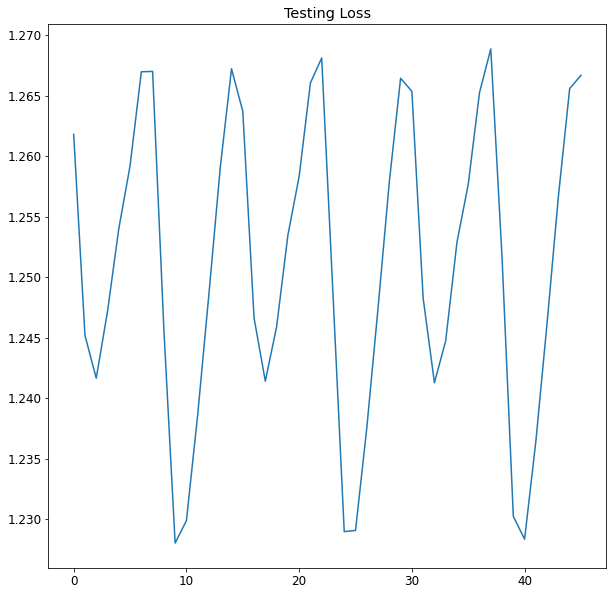

In [22]:
#Test

Testload = torch.utils.data.DataLoader(Test.T, batch_size=2)
net.predict(Testload)

net.testplot()

100%|██████████| 50/50 [14:15<00:00, 17.12s/it]


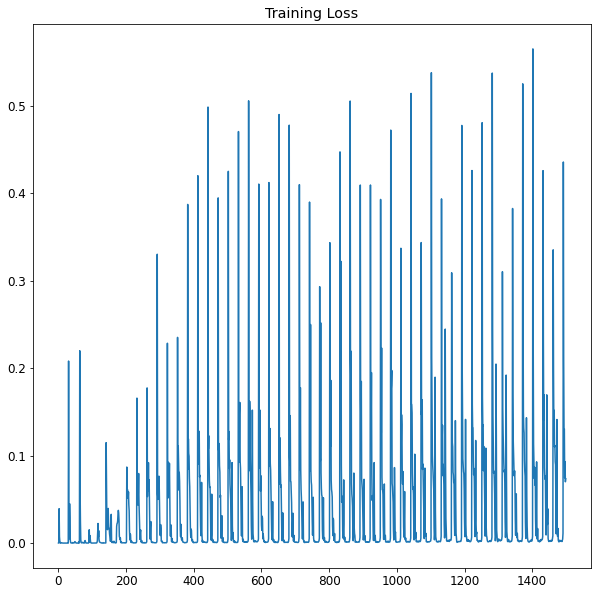

In [15]:
# Using reduced subspace U

U, S, VT = np.linalg.svd(X, full_matrices=False) 

#Training

P = 0.4
Train = U[:, :int(U.shape[1]*P)]
Test = U[:, int(U.shape[1]*P)-1:]

load = torch.utils.data.DataLoader(Train.T, batch_size=2)
net = Model(shapes=(n,m), lr=1e-2)
net.train(load, 50)

net.trainplot()

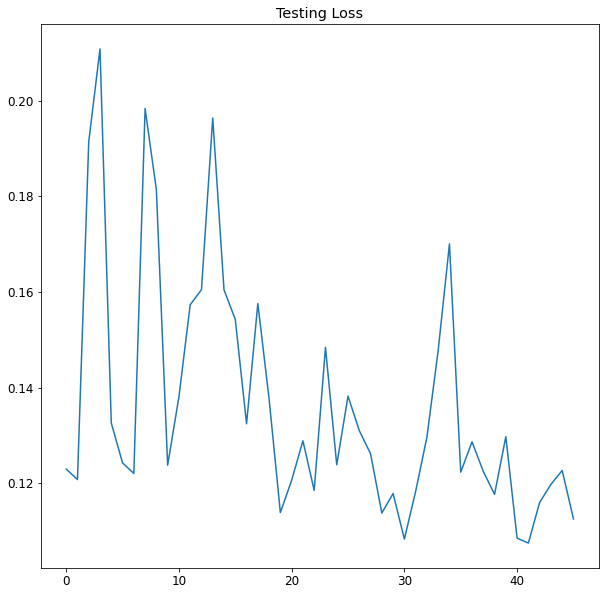

In [16]:
#Test

Test = torch.utils.data.DataLoader(Test.T, batch_size=2)
net.predict(Test)

net.testplot()